In [1]:
import Pkg; Pkg.activate(".")

  Activating project at `~/mit/InverseGraphics/notebooks/2d_slam`


In [2]:
import Pkg; Pkg.develop(path="./dev/GLRenderer")
import Pkg; Pkg.add(["Revise","PoseComposition", "Rotations","Plots","Images","Gen","Distributions","LinearAlgebra"])

   Resolving package versions...
  No Changes to `~/mit/InverseGraphics/notebooks/2d_slam/Project.toml`
  No Changes to `~/mit/InverseGraphics/notebooks/2d_slam/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/mit/InverseGraphics/notebooks/2d_slam/Project.toml`
  No Changes to `~/mit/InverseGraphics/notebooks/2d_slam/Manifest.toml`


In [3]:
import Revise
import GLRenderer
import PoseComposition
import Rotations
import Plots
import Images
import Gen
import Distributions
import LinearAlgebra

I = Images
PL = Plots

R = Rotations
P = PoseComposition
GL = GLRenderer

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
│   exception = Required dependency libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0] failed to load from a cache file.
└ @ Base loading.jl:1132
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
│   exception = ErrorException("Required dependency libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0] failed to load from a cache file.")
└ @ Base loading.jl:1132
┌ Info: Precompiling FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
└ @ Base loading.jl:1423
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
│   exception = ErrorException("Required dependency libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0] fai

GLRenderer

In [4]:
Revise.errors()
Revise.revise()

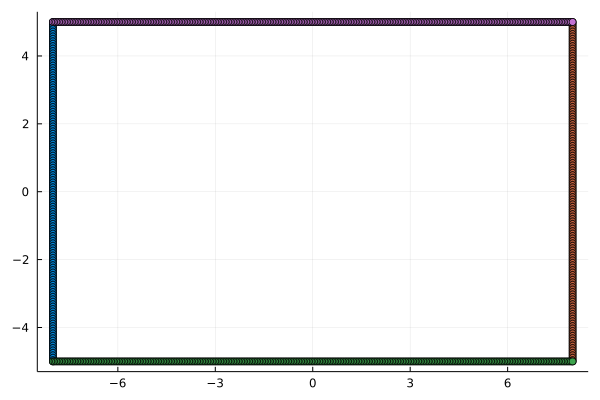

In [5]:
# Set room dimensions
room_width_bounds = (-8.0, 8.0)
room_height_bounds = (-5.0, 5.0)

# Create point clouds corresponding to the 4 walls of the room
resolution = 0.1
left_wall = []
right_wall = []
front_wall = []
back_wall = []
for z in room_height_bounds[1]:resolution/2.0:room_height_bounds[2]
    push!(left_wall, [room_width_bounds[1], 0.0, z])
    push!(right_wall, [room_width_bounds[2], 0.0, z])
end
for x in room_width_bounds[1]:resolution/2.0:room_width_bounds[2]
    push!(front_wall, [x, 0.0, room_height_bounds[1]])
    push!(back_wall, [x, 0.0, room_height_bounds[2]])
end
left_wall = hcat(left_wall...)
right_wall = hcat(right_wall...)
front_wall = hcat(front_wall...)
back_wall = hcat(back_wall...)

# Visualize the walls
room_cloud = hcat(left_wall,right_wall,front_wall,back_wall)
PL.scatter(left_wall[1,:], left_wall[3,:],label="")
PL.scatter!(right_wall[1,:], right_wall[3,:],label="")
PL.scatter!(front_wall[1,:], front_wall[3,:],label="")
PL.scatter!(back_wall[1,:], back_wall[3,:],label="")

In [6]:
# Convert the point clouds to meshes that can then be rendered using our RGBD renderer.
m1 = GL.mesh_from_voxelized_cloud(GL.voxelize(left_wall, resolution), resolution);
m2 = GL.mesh_from_voxelized_cloud(GL.voxelize(right_wall, resolution), resolution);
m3 = GL.mesh_from_voxelized_cloud(GL.voxelize(front_wall, resolution), resolution);
m4 = GL.mesh_from_voxelized_cloud(GL.voxelize(back_wall, resolution), resolution);

gl_version_for_shaders = "410"
true


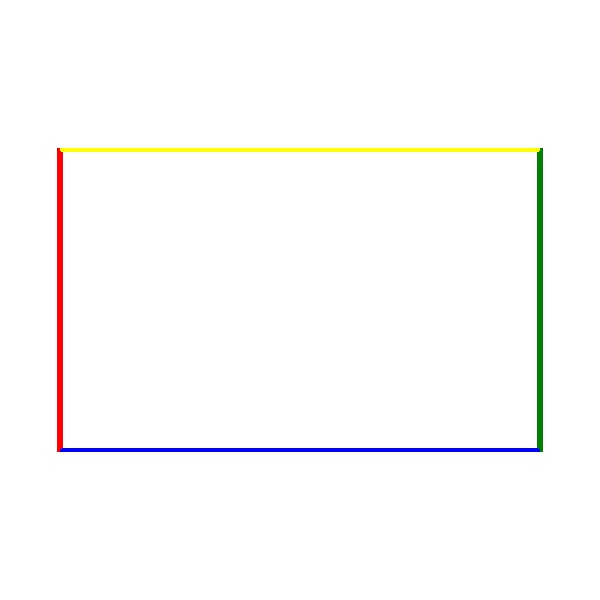

In [7]:
# Create renderer
renderer = GL.setup_renderer(GL.CameraIntrinsics(
    600, 600,
    300.0, 300.0,
    300.0,300.0,
    0.1, 60.0
), GL.RGBBasicMode())

# Add 4 wall objects.
GL.load_object!(renderer, m1)
GL.load_object!(renderer, m2)
GL.load_object!(renderer, m3)
GL.load_object!(renderer, m4)

# Set 4 wall colors
wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
# wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

# Render a top view so you can see what the room looks like.
rgb, depth = GL.gl_render(
    renderer,
    [1,2,3,4],
    [P.IDENTITY_POSE, P.IDENTITY_POSE,P.IDENTITY_POSE,P.IDENTITY_POSE],
    P.Pose([0.0, -10.0, 0.0], R.RotX(-pi/2))
    ; colors=wall_colors
)

GL.view_rgb_image(rgb)

In [8]:
# Since we are doing 2D SLAM, the agent only needs to look at a small slice of the world.
# So, we make the height of the rendered image 1
camera_intrinsics = GL.CameraIntrinsics(
    14, 1,
    5.0, 1.0,
    7.0, 0.5,
    0.1, 20.0
)
renderer = GL.setup_renderer(camera_intrinsics, GL.RGBBasicMode())
GL.load_object!(renderer, m1)
GL.load_object!(renderer, m2)
GL.load_object!(renderer, m3)
GL.load_object!(renderer, m4)

cam_pose = P.Pose(zeros(3),R.RotY(-pi/4+ 0.0))

@time rgb, depth = GL.gl_render(
    renderer, 
    [1,2,3,4], [P.IDENTITY_POSE, P.IDENTITY_POSE,P.IDENTITY_POSE,P.IDENTITY_POSE],
    cam_pose;
    colors=wall_colors
)
# color = map(argmin, eachcol(vcat([I.colordiff.(img, c) for c in wall_colors]...)))
GL.view_rgb_image(rgb)

gl_version_for_shaders = "410"
true
  0.112044 seconds (113.20 k allocations: 6.152 MiB, 34.63% gc time, 90.26% compilation time)


In [18]:
struct PoseUniform <: Gen.Distribution{P.Pose} end
const pose_uniform = PoseUniform()
function Gen.random(::PoseUniform, bounds_x, bounds_z)
    x = rand(Distributions.Uniform(bounds_x...))
    z = rand(Distributions.Uniform(bounds_z...))
    hd = rand(Distributions.Uniform(-2*pi, 2*pi))
    P.Pose([x, 0.0, z], R.RotY(hd))
end
function Gen.logpdf(::PoseUniform, pose::P.Pose, bounds_x, bounds_z)
    (
        Gen.logpdf(Gen.uniform, pose.pos[1], bounds_x...) +
        Gen.logpdf(Gen.uniform, pose.pos[3], bounds_z...) +
        Gen.logpdf(Gen.uniform, R.RotY(pose.orientation).theta, -2*pi, 2*pi)
    )   
end

struct ColorLikelihood <: Gen.Distribution{Array{<:Real}} end
const color_likelihood = ColorLikelihood()
function Gen.random(::ColorLikelihood, color, var)
    (x -> Gen.random(Gen.normal, x, var)).(color)
end
function Gen.logpdf(::ColorLikelihood, obs_color, color, var)
    sum((x -> Gen.logpdf(Gen.normal, x, 0.0, var)).(obs_color .- color))    
end

struct DepthLikelihood <: Gen.Distribution{Array{<:Real}} end
const depth_likelihood = DepthLikelihood()
function Gen.random(::DepthLikelihood, depth, var)
    (x -> Gen.random(Gen.normal, x, var)).(depth)
end
function Gen.logpdf(::DepthLikelihood, obs_depth, depth, var)
    sum((x -> Gen.logpdf(Gen.normal, x, 0.0, var)).(obs_depth .- depth))    
end

In [19]:
room_bounds_uniform_params = [room_width_bounds[1] room_width_bounds[2];room_height_bounds[1] room_height_bounds[2]]

2×2 Matrix{Float64}:
 -8.0  8.0
 -5.0  5.0

In [24]:
@Gen.gen function slam_model(room_width_bounds, room_height_bounds, wall_colors, depth_likelihood_var)
    pose ~ pose_uniform(room_width_bounds, room_height_bounds)
    
    rgb, depth = GL.gl_render(renderer, 
        [1,2,3,4], [P.IDENTITY_POSE, P.IDENTITY_POSE,P.IDENTITY_POSE,P.IDENTITY_POSE], pose;
        colors=wall_colors
    )
    
    depth_obs ~ depth_likelihood(depth, depth_likelihood_var)
    rgb_obs ~ color_likelihood(rgb, 0.01)

    return (pose=pose, rgb=rgb, depth=depth, depth_obs=depth_obs, rgb_obs=rgb_obs)
end

sense_rgb_addr() = :rgb_obs
sense_depth_addr() = :depth_obs
pose_addr() = :pose
get_pose(tr) = tr[pose_addr()]
get_gen_depth(tr) = Gen.get_retval(tr).depth
get_gen_rgb(tr) = Gen.get_retval(tr).rgb
get_sense_rgb(tr) = tr[sense_rgb_addr()]
get_sense_depth(tr) = tr[sense_depth_addr()]
get_wall_colors(tr) = Gen.get_args(tr)[3]

Gen.@load_generated_functions

function viz_env(;wall_colors=nothing)
    width = 5
    if isnothing(wall_colors)
        c = I.colorant"blue"
        PL.plot!([room_width_bounds[1],room_width_bounds[1]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=c,label=false)
        PL.plot!([room_width_bounds[2],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=c,label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[1]], linewidth=width,
            color=c,label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[2],room_height_bounds[2]], linewidth=width,
            color=c,label=false)
    else
        PL.plot!([room_width_bounds[1],room_width_bounds[1]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=wall_colors[1],label=false)
        PL.plot!([room_width_bounds[2],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=wall_colors[2],label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[1]], linewidth=width,
            color=wall_colors[3],label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[2],room_height_bounds[2]], linewidth=width,
            color=wall_colors[4],label=false)
        
    end
end

function viz_pose(pose; alpha=1.0)
    pos = pose.pos
    PL.scatter!([pos[1]], [pos[3]],color=:red,alpha=alpha,label=false)

    direction = pose.orientation * [0.0, 0.0, 1.0]
    PL.plot!([pos[1], pos[1]+direction[1]],
             [pos[3], pos[3]+direction[3]],
             arrow=true,color=:black, linewidth=2, alpha=alpha,label=false)
end

function viz_obs(tr)
    pose = get_pose(tr)
    depth = get_gen_depth(tr)
    sense = get_sense_depth(tr)
    
    cloud = GL.depth_image_to_point_cloud(depth, camera_intrinsics)
    cloud = GL.move_points_to_frame_b(cloud, pose)
    PL.scatter!(cloud[1,:], cloud[3,:], aspect_ratio=:equal, label=false, color=I.colorant"green")
    
    cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)
    cloud = GL.move_points_to_frame_b(cloud, pose)
    PL.scatter!(cloud[1,:], cloud[3,:], aspect_ratio=:equal, label=false, color=I.colorant"cyan")
end
    
function viz_trace(tr)
    PL.plot()
    viz_env(;wall_colors=get_wall_colors(tr))
    viz_pose(get_pose(tr))
    viz_obs(tr)
    PL.plot!()
end

function viz_corner(corner_pose)
    PL.scatter!([corner_pose.pos[1]], [corner_pose.pos[3]], label=false)
    pos = corner_pose.pos
    direction = corner_pose.orientation * [1.0, 0.0, 0.0]
    PL.plot!([pos[1], pos[1]+direction[1]],[pos[3], pos[3]+direction[3]],arrow=true,color=:red,linewidth=2, label=false)
end

viz_corner (generic function with 1 method)

# Part 1 - Enumeration

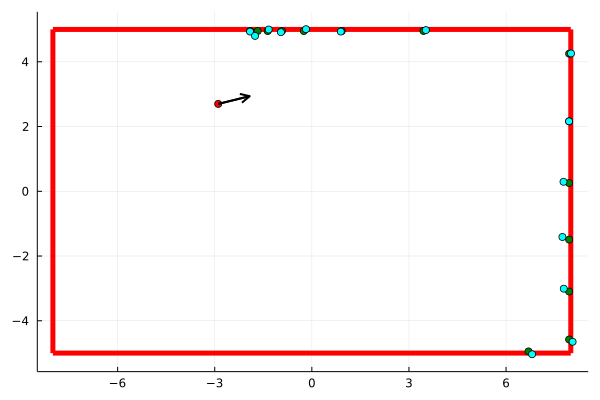

In [33]:
# Generate ground truth data from the model. The observations in this trace will be what we condition on
# and attempt to infer the pose.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, 0.1));
viz_trace(trace_ground_truth)

In [ ]:
GL.view_rgb_image(trace_ground_truth[sense_rgb_addr()])

In [ ]:
get_pose(trace_ground_truth)

In [ ]:
# FILL ME IN

# 1. Sweep over candidate poses
candidate_poses = [
    # FILL ME IN
];

@show size(candidate_poses)

# 2. Create traces for each of the candidate poses under the generative model. Hint (use Gen.update)
    # FILL ME IN

# 3. Get score of these traces.
    # FILL ME IN

# 4. Normalize the scores (remember they are log score).
    # FILL ME IN

# 5. Visualize the scores using Plots.heatmap. (You might need to flip the arrays and use aspect_ratio=1)
    # FILL ME IN


# Part 2 - Naive Inference

In [ ]:
# Generate ground truth data from the model. The observations in this trace will be what we condition on
# and attempt to infer the pose.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, 0.2));
viz_trace(trace_ground_truth)

In [ ]:
# 1. Use Gen.regenerate to resample the poses in trace_ground_truth and do this 50000 times.
# So the result should be a list of 50000 traces with different poses sampled from the prior.

candidate_traces = [
    # FILL ME IN
];

# 2. Get and normalize the scores (remember they are log score).
    # FILL ME IN

# 3. Visualize the poses with alpha (transparency) proportional to the weights using the snippet below
    # FILL ME IN


# Part 3 - Corner Detection

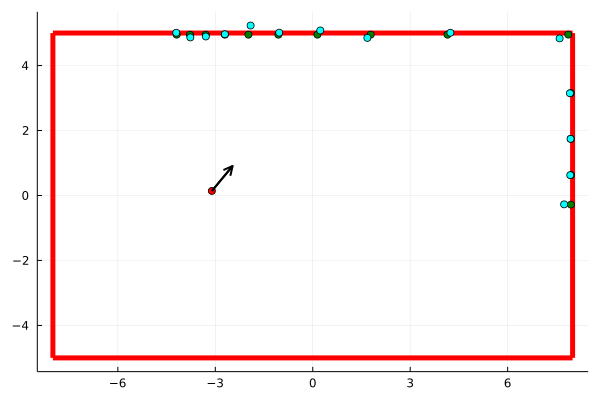

In [37]:
# Generate ground truth data from the model. The observations in this trace will be what we condition on
# and attempt to infer the pose.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, 0.1));
viz_trace(trace_ground_truth)

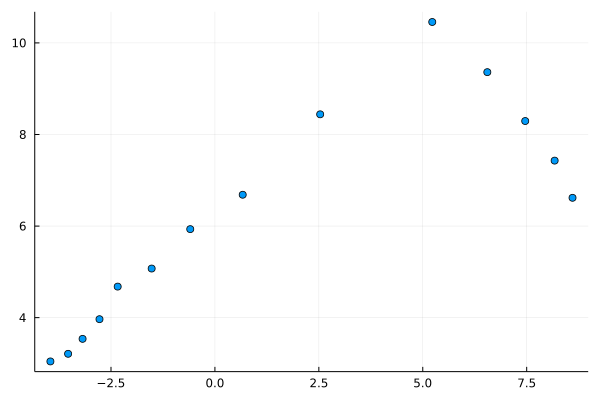

In [39]:
# We can take our observed depth map and convert it to a point cloud.
sense = get_sense_depth(trace_ground_truth)
cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)
PL.scatter(cloud[1,:], cloud[3,:], label="")

In [ ]:
# Write a function that takes this point cloud and finds the Pose of a corner (if it exists)
# Hint: The point cloud has a specific order that you can exploit. By looking at the differences
# between adjacent points, you can compute a "gradient" and find where the gradient changes significantly.

# Now, why did I say that we want to find the Pose of the corner? While the corner does have a position in space,
# it also has an orientation! We will assume that all corners for 90 degree angles. It is up to you how to
# define the orientation of the corner. But it will be a rotation of the form R.RotY(...)

function detect_corners_from_point_cloud(cloud)
    # FILL ME IN
end

In [ ]:
sense = get_sense_depth(trace_ground_truth)
cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)

corners = detect_corners_from_point_cloud(cloud)

PL.scatter(cloud[1,:], cloud[3,:], label="")
for c in corners
    viz_corner(c)
end
PL.plot!(xlim=(-20,20),ylim=(-20,20), aspect_ratio=:equal, label="")

In [ ]:
PL.plot()
viz_env()
corner_1 = P.Pose([room_width_bounds[1], 0.0, room_height_bounds[1]], R.RotY(-pi/4))
corner_2 = P.Pose([room_width_bounds[1], 0.0, room_height_bounds[2]], R.RotY(pi/4))
corner_3 = P.Pose([room_width_bounds[2], 0.0, room_height_bounds[1]], R.RotY(pi+pi/4))
corner_4 = P.Pose([room_width_bounds[2], 0.0, room_height_bounds[2]], R.RotY(pi-pi/4))
gt_corners = [corner_1,corner_2,corner_3,corner_4]
for c in gt_corners
    viz_corner(c)
end
PL.plot!()

In [ ]:
sense = get_sense_depth(trace_ground_truth)
cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)
corners = detect_corners_from_point_cloud(cloud)

# Use the detected corners `corners` and the known map corneres `gt_corners`
# to back calculate the possilbe poses of the agent. This will requires some Pose math.

# FILL ME IN


PL.plot()
viz_env()
for p in poses
   viz_pose(p) 
end
for c in gt_corners
   viz_corner(c) 
end
PL.plot!()

# Part 4 - Gaussian Distribution over Poses

In [ ]:
struct PoseGaussian <: Gen.Distribution{P.Pose} end
const pose_gaussian = PoseGaussian()

# HINT: `R.RotY(center_pose.orientation).theta` will be useful to extract the head direction from the Pose
# You can then add Gaussian noise to head direction and position variables
function Gen.random(::PoseGaussian, center_pose::P.Pose, translation_covariance, head_dir_variance)
    # FILL ME IN
    # P.Pose([x, 0.0, z], R.RotY(hd))
end

function Gen.logpdf(::PoseGaussian, pose::P.Pose, center_pose::P.Pose, translation_covariance, head_dir_variance)
    # FILL ME IN
end

In [ ]:
# Mixture over poses
mixture_of_pose_gaussians = Gen.HomogeneousMixture(pose_gaussian, [0, 2, 0])

@Gen.gen function pose_mixture_proposal(trace, poses, translation_covariance, head_dir_variance)
    n = length(poses)
    weights = ones(n) ./ n
    {pose_addr()} ~ mixture_of_pose_gaussians(
        weights, poses, cat([cov for _ in 1:n]..., dims=3), [var for _ in 1:n]
    )
end

In [ ]:
PL.plot()
viz_env()

# Sample from the PoseGaussian using Gen.random
sampled_poses = [
    # FILL ME IN
]


for p in sampled_poses
   viz_pose(p)
end
PL.plot!()

# Part 5 - Custom Proposal

In [ ]:
# Use Gen.metropolis_hastings with a custom proposal to do faster inference in the SLAM model.

# The custom proposal will be `pose_mixture_proposal` with the `poses` being the list of 4 poses
# computed by your corner detection + Pose back calculation.

    # FILL ME IN


# Part 6 - Parameter Exploration

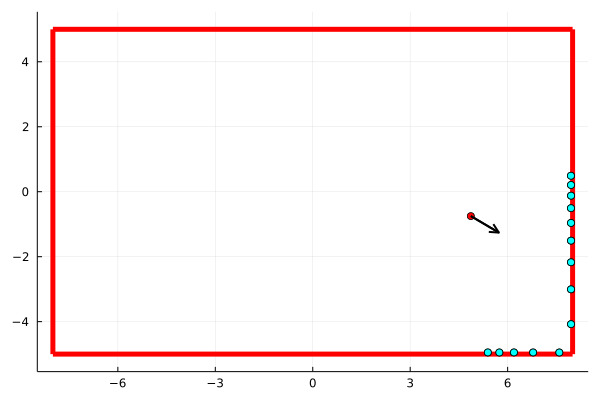

In [41]:
# Change the value of `depth_likelihood_variance` and investigate how this changes properties of the posterior.
# You can inspect the posterior using the enumeration procedure you wrote in part 1.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

depth_likelihood_variance = 0.001
trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, depth_likelihood_variance));
viz_trace(trace_ground_truth)